## import all needed liberary

In [164]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray,rgb2hsv
from skimage.exposure import equalize_adapthist 
from skimage import filters
from skimage import measure
from skimage.draw import polygon
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from skimage.draw import rectangle
import imutils
from skimage.exposure import histogram
from matplotlib.pyplot import bar


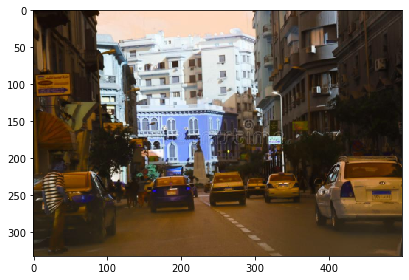

In [236]:
img_data1 =cv2.imread("dataset\data1.jpg")
img_data1 = imutils.resize(img_data1 , width = 500)
io.imshow(img_data1)


In [237]:
def Sobel (img):   
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad_norm = (grad * 255 / grad.max()).astype(np.uint8)
    return grad_norm


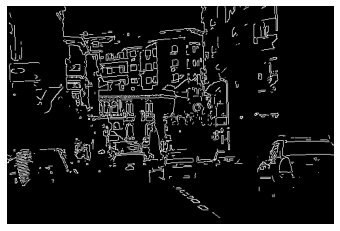

[[29 16 12 ... 28 30 34]
 [30 18 12 ... 29 31 36]
 [31 21 15 ... 32 35 41]
 ...
 [47 47 47 ... 44 39 35]
 [47 47 47 ... 44 39 35]
 [47 47 47 ... 44 38 35]]


In [238]:
def show_image (img):
    fig = plt.figure()
    plt.gray()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def image_preprocessing (img):
    '''
        in this function we are going to applying different preprocessing 
        techniques in the input image 

        prams:
                img 
    '''
    gray= cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)    # convert image to grayscale 
   # gray = cv2.bilateralFilter(gray_img, 11, 17, 17)
    edged = cv2.Canny(gray, 170, 200)
    
    #equalized_image = equalize_adapthist(gray_img) # applaying histogram equalization 
    
    #edged = Sobel(gray) # applaying edge detection using sobel algorithm  
    # we need to discuss the best way to get the best threshold 
    #result = ((edged >0.1))  # convert image to binary using thresholding value 
    return edged , gray


preprocessed_img  , gray_img= image_preprocessing(img_data1)
show_image(preprocessed_img)
io.imsave('result1.jpg' , preprocessed_img)
print(gray_img)

In [ ]:
def edge_img_processing(edge_img , img ):
    #Thresholding:
    #gray = cv2.cvtColor(edge_img, cv2.COLOR_BGR2GRAY)
    #T, edge_img_t = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    edge_img_t=edge_img
    #Finding contours (only need the external contour):
    cnts, _ = cv2.findContours(edge_img_t, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #cnts=sorted(cnts, key = cv2.contourArea, reverse = false)[:50] 

    plates = []
    for i, c in enumerate(cnts):
        x,y,w,h = cv2.boundingRect(c)
        area = w *h 
        aspect_ratio = w/h 
       
        if (1.5< aspect_ratio < 4 and area >650 and area < 5000 ):
        #if (1.4< aspect_ratio < 3.1  and area >500):
            plate = img[y:y+h, x:x+w]
            #plate[(plate>=100)] = 255
            #plate[(plate < 100)] = 0 
            #ints = np.sum(plate)
            ints = 0
            sz = np.shape(plate)
            print (sz)
            for j in range (0,sz[0]):
                for k in range (0,sz[1]):
                    ints = ints+plate[j][k]
            
            #print (ints)
            smin = sz[0]*sz[1]*255*0.4
            smax = sz[0]*sz[1]*255*0.9
            plates.append(img_data1[y-7:y+h+7, x-7:x+w+7])
            cv2.rectangle(img_data1, (x, y), (x + w, y + h), (100,0,0), 1)
            
            #print (ints,sm , plate[0])
           # if (ints > smin and ints < smax):
             

            

    #plates.sort(key=lambda by_x: by_x[1])
    #Writing the found contour into a folder
    
    print ("ssszzz")
    print (len(plates))
    for i, char in enumerate(plates):
        cv2.imwrite(f'Scannedplates/Char{i}.jpg', char )
    return  edge_img_t , img, plates

edge_img , img ,plates= edge_img_processing(preprocessed_img , gray_img)
print(np.array(plates).shape)
cv2.imshow('plates' , img)
cv2.waitKey()

(20, 44)
(23, 37)
(28, 64)
(25, 95)
(20, 45)
(26, 71)
ssszzz
6
(6,)


C:\Users\YOUSIF~1\AppData\Local\Temp/ipykernel_9696/3819537410.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(plates).shape)


In [234]:
def Get_Contours (img):
    h = img.shape[0]
    w = img.shape[1]
    
    # Getting all contours form the image 
    #contours = (measure.find_contours(img, 0.8))
    contours = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours_image =255* np.zeros((h, w), dtype=np.uint8)

    bounding_boxes = []
    img_with_boxes = img_data1.copy()
    
    #save contours in an image 
    for contour in contours:
        
        x_cordinates = contour[:,1]
        y_cordinates = contour[:,0]

        x_max = x_cordinates.max()
        y_max = y_cordinates.max()
        x_min = x_cordinates.min()
        y_min = y_cordinates.min()

        x_diff = x_max-x_min
        y_diff = y_max-y_min

        ratio = x_diff/y_diff
        area = x_diff * y_diff
        if ratio>1.9 and ratio<3.1 and area >1500 :
            print(area)
        #contours_image[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
            box  = [int(np.round(x_min)),int(np.round(x_max)),int(np.round(y_min)),int(np.round(y_max))]
            bounding_boxes.append(box)


    temp_img = img.copy()


    for box in bounding_boxes:
        [xmin,xmax,ymin,ymax] = box
        rr, cc = rectangle(start=(ymin,xmin),end=(ymax,xmax),shape=img.shape)
        img_with_boxes[rr,cc] = 0


    show_image(img_with_boxes)

    return  img_with_boxes


contours_image =Get_Contours(preprocessed_img)
io.imsave('result2.jpg' , contours_image)


TypeError: tuple indices must be integers or slices, not tuple

In [235]:
def contours_evaluation(contour):
    pass
    


In [ ]:
def Hough_Transform (img):
    img_shape = img.shape
    # image width and height
    x_max = img_shape[0]
    y_max = img_shape[1]
    
    theta_max = 1.0 * math.pi
    theta_min = 0.0
    
    r_min =0 
    r_max = math.hypot(x_max ,y_max)
    
    r_dim =200
    theta_dim =300
    
    houghSpace = np.zeros((r_dim , theta_dim))
    
    for x in range (x_max):
        for y in range(y_max):
            if img[x,y] ==0:continue
            for itheta  in range (theta_dim):
                theta = 1.0 *  itheta * theta_max /  theta_dim
                r = x * np.cos(theta) + y * np.sin(theta)
                ir = r_dim * (1.0 * r) /r_max
                
                houghSpace[np.round(ir).astype('int'),np.round(itheta).astype('int')]=  houghSpace[np.round(ir).astype('int'),np.round(itheta).astype('int')]+1
 
Hough_Transform(contours_image)               
    
    

In [ ]:
  '''
    ax.imshow(contours_image)
    for contour in contours:
            rr, cc = polygon(contour[:, 0], contour[:, 1], contours_image.shape)
            contours_image[rr, cc] = 0

            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax.axis('Image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    '''